Create a virtual environment for Python to run in:

`$ python3.8 -m venv .venv`

Activate the virtual environment

`$ source .venv/bin/activate`

Update pip and setuptools

`$ pip install --upgrade pip setuptools`

Install requirements

`$ pip install -r requirements.txt`


# Research

The initial goal is to determine the different variables that we can change to see how effieiency changes.
As of now, these are:
- GPU Frequency (14)
- CPU Frequency
- Memory Frequency
- Matrix Size (128 to 2048, with steps of 128) (16)
- Deep Learning Accelerators (DLAs)
- Tensor Cores (2)
- Data Types (Half, Float, Double) (3)

Ideally the goal would be to test all combinations of them, but as there are over 30,000 combinations it's unreasonable.

For the tests I chose to do all 14 of the GPU frequencies, Matrix sizes from 128 to 2048 with steps of 128 (16 total tests), with and without tensor cores, for 3 data tytpes (Half, Float, and Double). This gives 1344 tests.

## AGX Info

```
$ cat /etc/nv_tegra_release 
# R32 (release), REVISION: 4.4, GCID: 23942405, BOARD: t186ref, EABI: aarch64, DATE: Fri Oct 16 19:37:08 UTC 2020
```

```
$ nvcc -V
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_21:14:42_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89
```

## Nano Info
Todo

The `benchmark.cu` file is used for benchmarking the Jetson boards using various options.

Before each test, the CPU min/max frequency is set to it's maximum frequency (can also be changed later for more power usage info).

```
$ echo "2265600" | sudo tee /sys/devices/system/cpu/cpu0/cpufreq/scaling_{min,max}_freq
```

The GPU frequency is then set

AGX
```
$ echo "1377000000" | sudo tee /sys/devices/17000000.gv11b/devfreq/17000000.gv11b/{min,max}_freq
```

Nano
```
$ todo
```

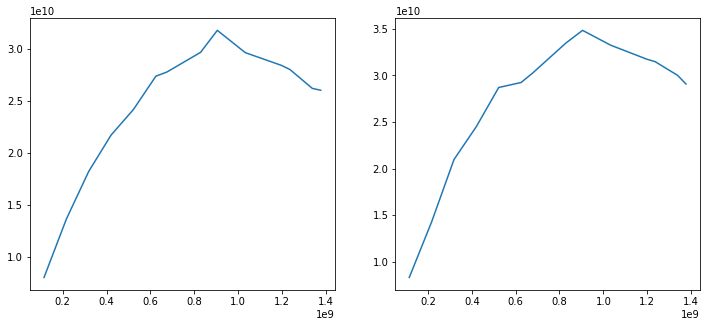

In [53]:
import os
import matplotlib.pyplot as plt

path = "./data/AGX/"
files = os.listdir(path)

data = []

for file_name in files:
    temp = {
        # Inputs
        "datatype": "",
        "matrix_size": -1,
        "tensor": None,
        "gpu_frequency": -1,

        # Results
        "power_usage": [],
        "flops": -1,
        
        # Calculated Results
        "avg_power": -1,
        "flops_per_watt": -1
    }
    with open(path+file_name, "r") as f:
        temp['datatype'], temp['matrix_size'], temp['tensor'], temp['gpu_frequency'] = file_name.split(".")[0].split("-")[1:]
        temp['matrix_size'] = float(temp['matrix_size'])
        temp['tensor'] = True if temp['tensor'].lower() == "tensor" else False
        temp['gpu_frequency'] = float(temp['gpu_frequency'])

        file_data = f.readlines()

        _, temp['power_usage'] = zip(*[d.strip().split(",") for d in file_data[:-1]])
        temp['power_usage'] = list(map(float, temp['power_usage']))
        temp['avg_power'] = sum(temp['power_usage'])/len(temp['power_usage'])

        temp['flops'] = float(file_data[-1])

        temp['flops_per_watt'] = temp['flops'] / temp['avg_power']
    
    data.append(temp)

search1 = {
    "datatype": "float",
    "tensor": True,
    "matrix_size": 1024
}

search2 = {
    "datatype": "float",
    "tensor": False,
    "matrix_size": 2048
}

results1 = [d for d in data if search1.items() <= d.items()]
results2 = [d for d in data if search2.items() <= d.items()]

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(5)

x1, y1 = zip(*sorted([(r['gpu_frequency'], r['flops_per_watt']) for r in results1], key=lambda d : d[0]))
x2, y2 = zip(*sorted([(r['gpu_frequency'], r['flops_per_watt']) for r in results2], key=lambda d : d[0]))
ax[0].plot(x1, y1)
ax[1].plot(x2, y2)

plt.show()